In [1]:
# import python packages 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# import torch packages
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

# import other packages
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [112]:
# load and process data
df= pd.read_csv(r'nfl_betting-main/scraped_data/elo_pfr_betting_data.csv')

# drop unnecessary columns (no need if you already have it in your nfl strategy)
df = df.drop(['qb1','qb2', 'playoff','date''Unnamed: 0'], axis=1)
df = df.sort_values(by = ['season', 'team1'], ascending = True, ignore_index=True)
target = 'qb2_game_value'    # column name to predict
df = df.dropna(axis=1)

# shift prediction up by 1

In [96]:
for i in range(df.shape[0]-1):
    if df['team1'][i] == df['team1'][i+1]:
        df[target][i] = df[target][i+1]
        
    else:
        df[target][i] = df[target][i]
df[target]   

<ipython-input-96-3dc017602668>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target][i] = df[target][i+1]
<ipython-input-96-3dc017602668>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target][i] = df[target][i]


0        -99.361634
1        -48.771096
2        -86.153471
3        -58.861749
4        135.824107
            ...    
12540    118.180242
12541    180.379935
12542    -82.000841
12543    143.167774
12544    143.167774
Name: qb2_game_value, Length: 12545, dtype: float64

# # Standardize features (No need if you have it in your code) 

In [97]:
features = list(df.columns.difference([target,'team1','team2', 'spread_result', 'ou_result', 'home_third_down_success', 'Unnamed: 0', 'Unnamed: 0.1','away_third_down_success']))
test_start = int(255*8)
df_train = df.loc[:test_start].copy()
df_test  = df.loc[test_start:].copy()

target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in range(len(features)):
    mean = df_train[features[c]].mean()
    stdev = df_train[features[c]].std()

    df_train[features[c]] = (df_train[features[c]] - mean) / stdev
    df_train[features[c]] = (df_train[features[c]] - mean) / stdev


# Onehot encode categorical columns

### P.S. ou and spread have NaN's

In [99]:
ohe = OneHotEncoder(sparse=False, categories='auto').fit_transform(df[['team1','team2']])
newdf = df.drop(columns=['team1','team2'])
ohe_df = pd.DataFrame(ohe)
df = pd.concat([newdf, ohe_df],axis=1)

## LSTM Model sequence length is 255 games i.e 1 season

In [100]:
# Create a dataset that pytorch loader can work with 
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [101]:
sequence_length = 255

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

In [102]:
# Set the dataset in pytorch dataloader
torch.manual_seed(99)
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [103]:
X, y = next(iter(train_loader))
print(X.shape)
print(y.shape)
print(X)

torch.Size([5, 255, 67])
torch.Size([5])
tensor([[[-1.2496e+00, -2.4885e-01, -2.9943e+00,  ..., -1.7929e+00,
          -6.6406e+02, -6.6347e+02],
         [-6.9174e-01,  6.4530e-01, -3.0694e+00,  ..., -1.8322e+00,
          -6.6406e+02, -6.6347e+02],
         [-2.3655e+00, -2.0371e+00, -3.1295e+00,  ..., -1.7143e+00,
          -6.6406e+02, -6.6347e+02],
         ...,
         [-1.8076e+00, -1.1430e+00, -3.1897e+00,  ..., -1.8224e+00,
          -6.6394e+02, -6.6336e+02],
         [-2.3655e+00, -2.0371e+00, -3.4602e+00,  ..., -1.9206e+00,
          -6.6394e+02, -6.6336e+02],
         [-1.8076e+00, -2.0371e+00, -2.9943e+00,  ..., -1.7831e+00,
          -6.6394e+02, -6.6336e+02]],

        [[-2.3655e+00, -2.0371e+00, -3.3250e+00,  ..., -1.7831e+00,
          -6.6440e+02, -6.6381e+02],
         [-6.9174e-01, -1.1430e+00, -3.4001e+00,  ..., -1.8224e+00,
          -6.6440e+02, -6.6381e+02],
         [-1.8076e+00, -2.0371e+00, -3.2949e+00,  ..., -1.8518e+00,
          -6.6440e+02, -6.6381e+02]

In [104]:
# model 
class RegressionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(RegressionLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size, 
                            num_layers = self.num_layers, 
                            dropout = self.dropout, 
                            batch_first = True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_() 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        _, (hn, _) = self.lstm(x,(h0,c0))
        out = self.linear(hn[0]).flatten()
        
        return out 

In [ ]:
# model 
class ClassifcationSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(RegressionLSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size, 
                            num_layers = self.num_layers, 
                            dropout = self.dropout, 
                            batch_first = True)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=1)
        
    def forward(self,x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_() 
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).requires_grad_()
        
        _, (hn, _) = self.lstm(x,(h0,c0))
        score = self.linear(hn[0]).flatten()
        out = F.log_softmax(out, dim=1)
        return out 

In [105]:
# hyperparameters
lr = 5e-5
epoch = 10
input_size = len(features)
hidden_size = 16
num_layers = 3
dropout = 0.1

model = RegressionLSTM(input_size=input_size, 
                       hidden_size=hidden_size, 
                       num_layers= num_layers,
                       dropout= dropout
                      )
loss_func = nn.MSELoss()
criterion = torch.optim.Adam(model.parameters(), lr = lr)

In [106]:
# Training 
def train(data, model, loss_func, optimizer):
    n_batches = len(data)
    total_loss = 0
    model.train()
    
    for x,y in data:
        output= model(x)
        loss = loss_func(output, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    mean_loss = total_loss/n_batches
    print(f'Training loss: {mean_loss}')
    return mean_loss
    

def test(data,model,loss_func):
    n_batches = len(data)
    total_loss = 0
    
    model.eval()
    with torch.no_grad():
        for x, y in data:
            output= model(x)
            total_loss += loss_func(output,y).item()
            
    mean_loss = total_loss/n_batches
    print(f'Test loss: {mean_loss}')
    
    return mean_loss
        

In [107]:
# prediction function

def predict(data, model):
    
    output = torch.tensor([])
    model.eval()
    
    with torch.no_grad():
        for X,_ in data:
            y_fit = model(X)
            output = torch.cat((output,y_fit), 0)
    
    return output



In [113]:
# Run lstm 
trainloss = []
testloss = []
for i in range(epoch):
    print(f'Epoch {i}\n -----')
    train_loss = train(train_loader, model, loss_func, optimizer=criterion)
    trainloss.append(train_loss)
    test_loss  = test(test_loader, model, loss_func)
    testloss.append(test_loss)    
    print()

Epoch 0
 -----
Training loss: 17575.34794008586
Test loss: 27274.779352020163

Epoch 1
 -----
Training loss: 17555.13382793697
Test loss: 27265.34620125438

Epoch 2
 -----
Training loss: 17645.664653750096
Test loss: 27258.355613022177

Epoch 3
 -----
Training loss: 17569.46296807548
Test loss: 27252.243763708942

Epoch 4
 -----
Training loss: 17495.005434516588
Test loss: 27246.47761749892

Epoch 5
 -----
Training loss: 17495.437710713057
Test loss: 27240.848270327293

Epoch 6
 -----
Training loss: 17490.061907556064
Test loss: 27235.271689275625

Epoch 7
 -----
Training loss: 17471.03880642096
Test loss: 27229.728254380876

Epoch 8
 -----
Training loss: 17482.713205649976
Test loss: 27224.287529808746

Epoch 9
 -----
Training loss: 17426.095062032015
Test loss: 27218.86494087753



In [114]:
# prediction

train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

y_pred = "Game Prediction"
df_train[y_pred] = predict(train_eval_loader, model).numpy()
df_test[y_pred]  = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, y_pred]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean
    
df_out.to_csv(f'{target}.csv', index=False) 


In [115]:
df_out

,qb2_game_value,Game Prediction
0,-11154.444949,278.997730
1,-5439.287025,278.997730
2,-9662.333197,278.997730
3,-6579.217108,278.997730
4,15414.231465,278.997730
...,...,...
12540,13421.023205,117.812566
12541,20447.654704,117.812566
12542,-9193.215055,117.812566
12543,16243.837492,117.812566


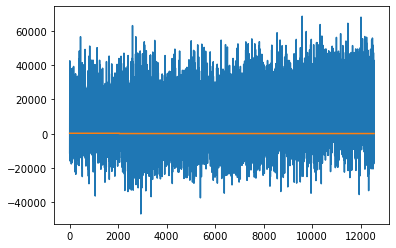

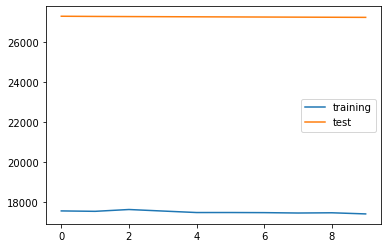

In [121]:
plt.plot(df_out['qb2_game_value'])
plt.plot(df_out['Game Prediction'])
plt.show()

plt.plot(trainloss, label='training')
plt.plot(testloss, label = 'test')
plt.legend()
plt.show()